# **PARALLEL CHESS ENGINE**

## **THÔNG TIN NHÓM**

| Họ và tên sinh viên |   MSSV   |
|---------------------|----------|
| Võ Văn Hiếu         | 19120511 |
| Huỳnh Đức Huy       | 19120526 |
| Vương Thế Khang     | 19120539 |

## **THƯ VIỆN**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import matplotlib.pyplot as plt
import pandas as pd
import time

## **ĐỀ TÀI**

Đề tài của nhóm là **song song hóa thuật toán tìm kiếm minimax trong cờ vua**.

Nhóm đã cài đặt 3 phiên bản: *1 phiên bản tuần tự* và *2 phiên bản song song*.

Để đánh giá các phiên bản của thuật toán, ta đánh giá:
- Thời gian thực thi của phiên bản
- Số lượng node của cây minimax được duyệt qua
- Kết quả tìm được (lấy kết quả của phiên bản tuần tự làm chuẩn)

## **BIỂU DIỄN MỘT THẾ CỜ**

### **QUÂN CỜ VÀ BÀN CỜ**

**Quân cờ**

Trong cờ vua, có:
- *2 bên* (trắng và đen)
- *6 loại quân cờ* (vua, tốt, mã, tượng, xe, hậu)

Để biểu diễn một quân cờ, ta sử dụng một số nguyên 8 bit, trong đó:
- 3 bit đầu biểu diễn loại quân cờ

| Loại quân cờ | 3 bit biểu diễn |
|--------------|-----------------|
| Trống        | `000`           |
| Vua          | `001`           |
| Tốt          | `010`           |
| Mã           | `011`           |
| Tượng        | `100`           |
| Xe           | `101`           |
| Hậu          | `110`           |

- Bit thứ 4 biểu diễn bên mà quân cờ đó thuộc về:
    - `0`: đen
    - `1`: trắng

**Bàn cờ**

Trên CPU và GPU, một bàn cờ được biểu diễn bằng một mảng 64 số nguyên 8 bit, mỗi số nguyên biểu diễn một quân cờ trên một ô của bàn cờ.

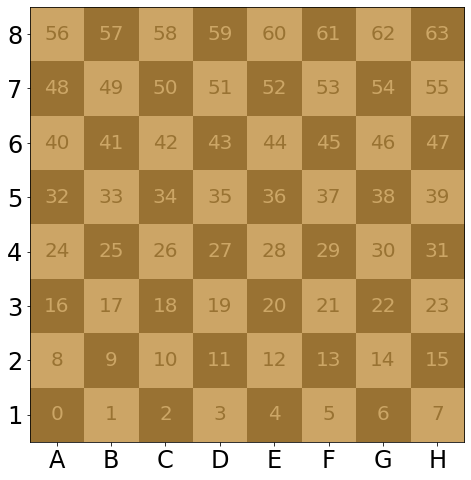

In [2]:
board = np.ones((8, 8)) - np.indices((8, 8)).sum(axis=0) % 2

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.tick_params(axis = 'both', labelsize = 24)
ax.set_xticks(np.arange(8))
ax.set_xticklabels([ 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H' ])
ax.set_yticks(np.arange(8))
ax.set_yticklabels([ '8', '7', '6', '5', '4', '3', '2', '1' ])

ax.imshow(board, cmap=ListedColormap([[0.6, 0.45, 0.2, 1.0], [0.8, 0.65, 0.4, 1.0]]))

for i in range(64):
    r = i // 8
    c = i % 8

    color = [0.6, 0.45, 0.2, 1.0] if ((r + c) % 2 != 0) else [0.8, 0.65, 0.4, 1.0]
    ax.text(c, 7 - r, str(i), fontsize = 20, color = color, horizontalalignment = 'center', verticalalignment = 'center')

### **QUYỀN NHẬP THÀNH**

Trong cờ vua, vua có thể nhập thành nếu như có quyền. Ban đầu, mỗi vua đều có thể nhập thành 2 bên (bên vua, bên hậu) nếu như đáp ứng được điều kiện nhập thành.

Trên CPU, ta sử dụng 4 biến bool để biểu diễn quyền nhập thành, lần lượt là:
- Quyền vua trắng nhập thành bên vua
- Quyền vua trắng nhập thành bên hậu
- Quyền vua đen nhập thành bên vua
- Quyền vua đen nhập thành bên hậu

Trên GPU, để hạn chế kích thước dữ liệu khi sao chép dữ liệu giữa CPU và GPU, ta sử dụng 1 số nguyên 8 bit, với 4 bit đầu mỗi bit tương ứng với 1 biến bool trên CPU.

### **TỐT QUA ĐƯỜNG**

Tại vị trí mặc định ban đầu, quân tốt có thể bước 1 hoặc 2 bước. Khi bước 2 bước, quân tốt đó trở thành *tốt qua đường* trong vòng 1 lượt. Khi đó, bên đối phương có thể *bắt tốt qua đường*.

Trên CPU và GPU, ta dùng 1 số nguyên trong [-1, 64) để biểu diễn tốt qua đường hiện tại của ván cờ, trong đó:
- -1 nghĩa là tại thời điểm đó, không có tốt qua đường
- [0, 64) nghĩa là số nguyên đó đánh dấu vị trí mà tốt qua đường vừa đi qua

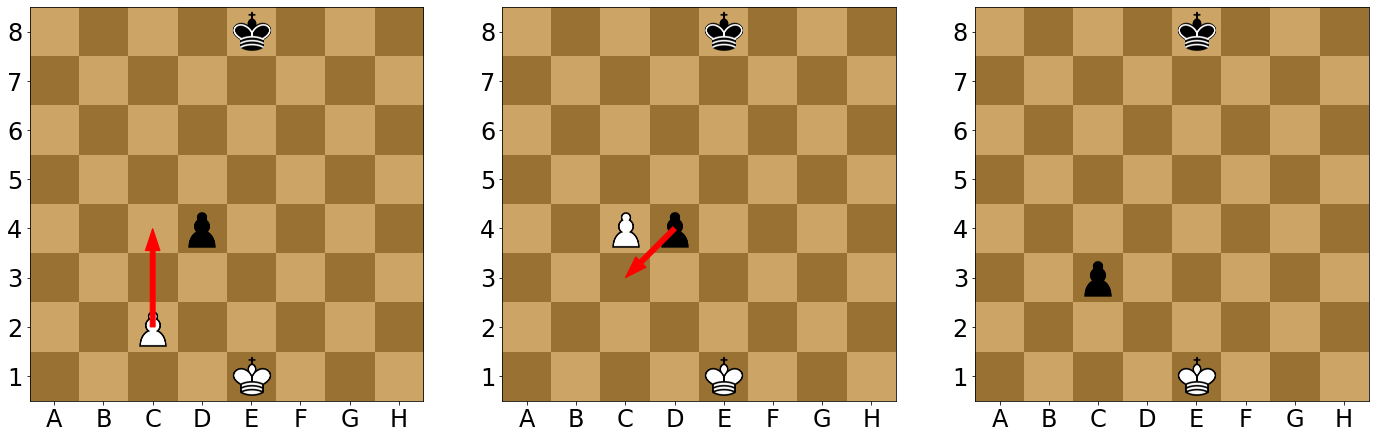

In [3]:
fig, ax = plt.subplots(1, 3, figsize = (24, 8))

game = ChessGame('4k3/8/8/8/3p4/8/2P5/4K3 w - - 0 1')

move1 = Move(10, 26)
game.plot(ax = ax[0], moves = [move1])
game.move(move1)

move2 = Move(27, 18, en_passant_target = 18)
game.plot(ax = ax[1], moves = [move2])
game.move(move2)

game.plot(ax = ax[2])

### **LUẬT HÒA 50 NƯỚC**

Trong một ván cờ, nếu như mỗi bên đi được 50 nước (tổng cộng 100 nước đi liên tiếp) mà không có tiến triển gì thì sẽ được xem là hòa cờ.

Một nước đi được xem là có tiến triển nếu như trong nước đi đó:
- Bắt được quân cờ của đối phương
- Là nước đi của tốt

Trong một ván cờ có một chỉ số gọi là *halfmove*. Khi một nước đi được xem là có tiến triển được thực hiện, halfmove được gán về 0. Ngược lại, nếu như nước đi không có tiến triển được thực hiện, halfmove tăng lên 1. Khi halmove đạt giá trị 100 thì ván cờ được xem là hòa.

Trên CPU và GPU, halfmove được biểu diễn là một số nguyên.

## **ĐÁNH GIÁ BÀN CỜ**

Để đánh giá một bàn cờ, ta dựa vào độ chênh lệch về giá trị của các quân cờ giữa hai bên.

Một quân cờ có hai giá trị:
- Giá trị về chất: Phụ thuộc vào loại quân cờ

![Piece base values](./images/piece_base_values.png "Piece base values")

- Giá tri về vị trí: Phụ thuộc vào vị trí của quân cờ trên bàn cờ. Mỗi loại quân cờ có một mảng 64 giá trị tương ứng với 64 vị trí trên bàn cờ. Mảng này lưu giá trị về vị trí của loại quân cờ đó nếu quân cờ đó là quân trắng. Các mảng giá trị này được gọi là [*piece-square tables*](https://www.chessprogramming.org/Simplified_Evaluation_Function#Piece-Square_Tables).

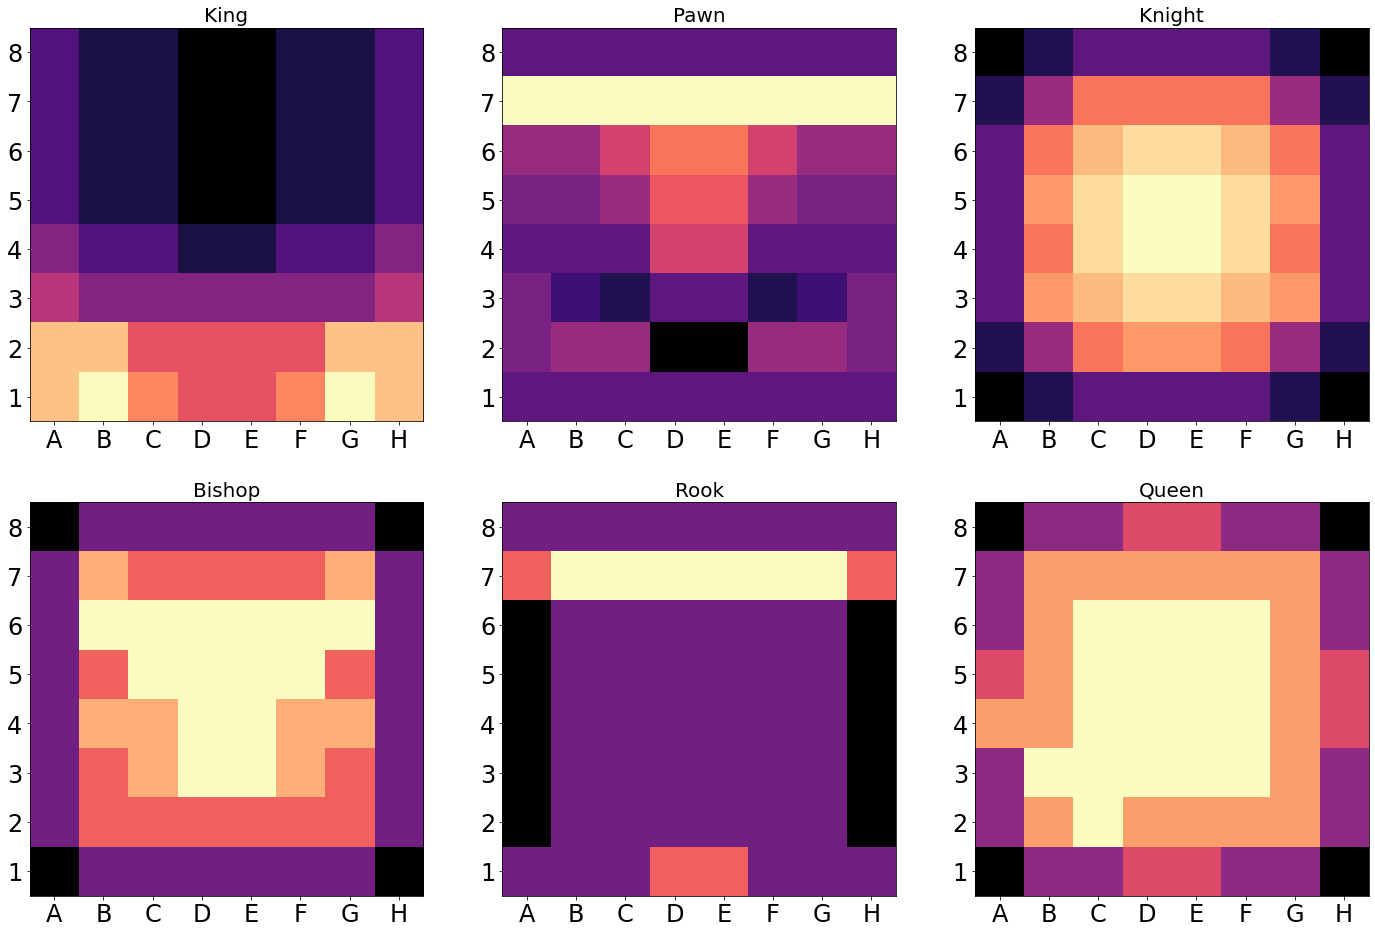

In [4]:
fig, axs = plt.subplots(2, 3, figsize = (24, 16))

for row in range(2):
    for col in range(3):
        axs[row, col].tick_params(axis='both', labelsize=24)
        axs[row, col].set_xticks(np.arange(8))
        axs[row, col].set_xticklabels([ 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H' ])
        axs[row, col].set_yticks(np.arange(8))
        axs[row, col].set_yticklabels([ '8', '7', '6', '5', '4', '3', '2', '1' ])

axs[0, 0].set_title('King', fontdict={'fontsize': 20, 'fontweight': 'medium'})
axs[0, 0].imshow(np.flip(np.array(ChessPieces.PIECE_SQUARE_TABLE_KING).reshape((8, 8)), axis = 0), cmap = 'magma')

axs[0, 1].set_title('Pawn', fontdict={'fontsize': 20, 'fontweight': 'medium'})
axs[0, 1].imshow(np.flip(np.array(ChessPieces.PIECE_SQUARE_TABLE_PAWN).reshape((8, 8)), axis = 0), cmap = 'magma')

axs[0, 2].set_title('Knight', fontdict={'fontsize': 20, 'fontweight': 'medium'})
axs[0, 2].imshow(np.flip(np.array(ChessPieces.PIECE_SQUARE_TABLE_KNIGHT).reshape((8, 8)), axis = 0), cmap = 'magma')

axs[1, 0].set_title('Bishop', fontdict={'fontsize': 20, 'fontweight': 'medium'})
axs[1, 0].imshow(np.flip(np.array(ChessPieces.PIECE_SQUARE_TABLE_BISHOP).reshape((8, 8)), axis = 0), cmap = 'magma')

axs[1, 1].set_title('Rook', fontdict={'fontsize': 20, 'fontweight': 'medium'})
axs[1, 1].imshow(np.flip(np.array(ChessPieces.PIECE_SQUARE_TABLE_ROOK).reshape((8, 8)), axis = 0), cmap = 'magma')

axs[1, 2].set_title('Queen', fontdict={'fontsize': 20, 'fontweight': 'medium'})
axs[1, 2].imshow(np.flip(np.array(ChessPieces.PIECE_SQUARE_TABLE_QUEEN).reshape((8, 8)), axis = 0), cmap = 'magma')

## **THUẬT TOÁN TÌM KIẾM MINIMAX**

In [5]:
def handle_output(output, version_name, results_df = None):
    if results_df is None:
        results_df = pd.DataFrame()

    lines = output.stdout.split('\n')

    fen            = lines[0][lines[0].find(':') + 2:]
    execution_time = float(lines[1].split()[3])
    score          = float(lines[2].split()[2])
    n_evaluations  = int(lines[3].split()[3])
    encoded_move   = int(lines[4].split()[3])
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Version'         : [version_name],
        'Score'           : [score],
        'Execution time'  : [execution_time],
        'No. Evaluations' : [n_evaluations]
    }, index=[results_df.shape[0]])])
    
    game = ChessGame(fen)
    move = decode_move(encoded_move, game.side_to_move())
    game.plot(moves = [move])

    return results_df

### **PHIÊN BẢN TUẦN TỰ**

#### MINIMAX CƠ BẢN

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

def sequencial_minimax(chess_game, search_depth):

    # If reach search limit, return the score of the current chessboard
    if search_depth == 0:
        return evaluate_board(chess_game)


    # Get all possible moves
    moves = possible_moves(chess_game)


    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Evaluate each possible move and find the best one
    result = -inf
    for move in moves:
        chess_game.move(move)
        evaluation = -sequencial_minimax(chess_game, search_depth - 1)
        chess_game.undo_move()

        result = max(result, evaluation)

    return result
```

In [6]:
%%writefile sequencial_minimax_basic.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)
start = time.time()
move, score = find_move(game, args.search_depth, version = 0)
end = time.time()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting sequencial_minimax_basic.py


In [7]:
%%capture output
!python sequencial_minimax_basic.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,359.34437,3107697


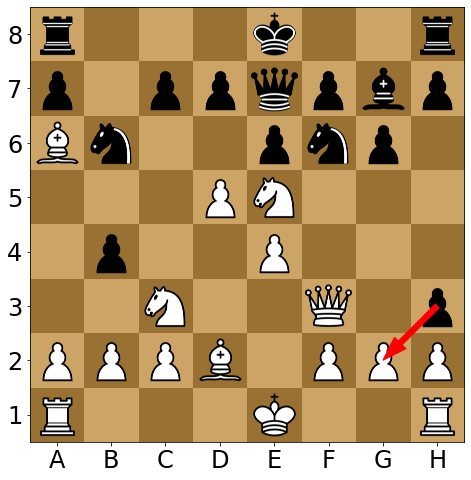

In [8]:
results_df = handle_output(output, 'Sequencial (basic)')
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

def sequencial_minimax_alpha_beta(chess_game, search_depth, alpha = -inf, beta = inf):

    # If reach search limit, return the score of the current chessboard
    if search_depth == 0:
        return evaluate_board(chess_game)


    # Get all possible moves
    moves = possible_moves(chess_game)


    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Evaluate each possible move and find the best one
    for move in moves:
        chess_game.move(move)
        evaluation = -sequencial_minimax_alpha_beta(chess_game, search_depth - 1, -beta, -alpha)
        chess_game.undo_move()

        if evaluation >= beta:
            return beta

        alpha = max(alpha, evaluation)

    return alpha

```

In [9]:
%%writefile sequencial_minimax_alphabeta.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)
start = time.time()
move, score = find_move(game, args.search_depth, version = 1)
end = time.time()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting sequencial_minimax_alphabeta.py


In [10]:
%%capture output
!python sequencial_minimax_alphabeta.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,359.34437,3107697
1,Sequencial (alpha-beta),-1.2,2.14137,16293


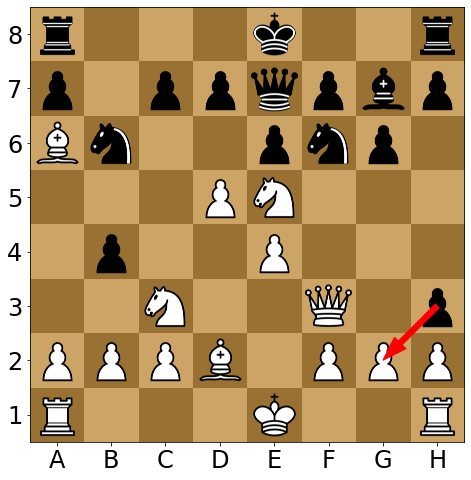

In [11]:
results_df = handle_output(output, 'Sequencial (alpha-beta)',  results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

def sort_moves(moves): # Move sorting function
    ...

def sequencial_minimax_alpha_beta_move_sorting(chess_game, search_depth, alpha = -inf, beta = inf):

    # If reach search limit, return the score of the current chessboard
    if search_depth == 0:
        return evaluate_board(chess_game)


    # Get all possible moves and sort
    moves = possible_moves(chess_game)
    moves = sort_moves(moves)

    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Evaluate each possible move and find the best one
    for move in moves:
        chess_game.move(move)
        evaluation = -sequencial_minimax_alpha_beta_move_sorting(chess_game, search_depth - 1, -beta, -alpha)
        chess_game.undo_move()

        if evaluation >= beta:
            return beta

        alpha = max(alpha, evaluation)

    return alpha

```

In [12]:
%%writefile sequencial_minimax_alphabeta_movesorting.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)
start = time.time()
move, score = find_move(game, args.search_depth, version = 2)
end = time.time()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting sequencial_minimax_alphabeta_movesorting.py


In [13]:
%%capture output
!python sequencial_minimax_alphabeta_movesorting.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,359.34437,3107697
1,Sequencial (alpha-beta),-1.2,2.14137,16293
2,Sequencial (alpha-beta + move sorting),-1.2,1.40612,8579


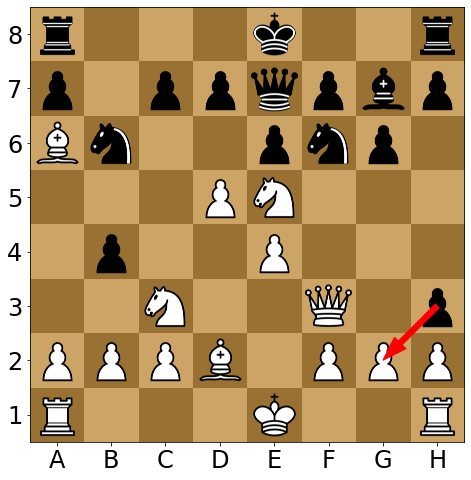

In [14]:
results_df = handle_output(output, 'Sequencial (alpha-beta + move sorting)', results_df)
results_df

### **PHIÊN BẢN SONG SONG 1**

#### Ý TƯỞNG

Cách tiếp cận đầu tiên khi song song hóa thuật toán tìm kiếm minimax là song song hóa việc tính điểm cho các node lá của cây minimax.

Phiên bản này tương tự như phiên bản tuần tự, chỉ khác là tại `search_depth = 1`, ta tính điểm cho tất cả các nước đi tiếp theo song song trên GPU. 

![Parallel v1 diagram](./images/parallel_v1_diagram.png "Parallel v1 diagram")

Phiên bản này sử dụng 1 hàm kernel, với:
- Đầu vào là các bàn cờ ứng với các nước đi tiếp theo (mỗi bàn cờ là một mảng 64 số nguyên 8 bit)
- Đầu ra là các điểm số ứng với mỗi bàn cờ

Kernel sử dụng tối đa số lượng thread trên 1 block mà GPU cho phép. Cứ mỗi 64 thread liên tiếp sẽ được dùng để tính điểm cho một bàn cờ. Mỗi thread sẽ tính giá trị của quân cờ tương ứng. Sau đó ta thực hiện reduce để tính tổng giá trị các quân cờ trên mỗi bàn cờ.

Kernel này sử dụng shared memory với kích thước `smem_size = block_size * size(np.float32)`.

```python

@cuda.jit(device = True)
def piece_value_device(piece, piece_position):  # Piece evaluation function on device
    ...

@cuda.jit
def kernel_v1(boards, out_scores):
    tid = cuda.grid(1)  # Thread ID
    bid = tid // 64     # Board ID
    pid = tid % 64      # Piece ID, or piece position [0, 64)

    s_evaluation_scores = cuda.shared.array(0, dtype = np.float32)  # Dynamic shared memory of size `smem_size`

    n_boards = boards.size // 64    # Number of boards

    # Calculate score for each piece
    if bid < n_boards:
        s_evaluation_scores[cuda.threadIdx.x] = piece_value_device(boards[tid], pid)
    cuda.syncthreads()

    # Reduce to sum
    stride = 32
    while stride > 0:
        if bid < n_boards and pid < stride:
            s_evaluation_scores[cuda.threadIdx.x] += s_evaluation_scores[cuda.threadIdx.x + stride]
        cuda.syncthreads()
        stride = stride // 2

    # Result
    if bid < n_boards and pid == 0:
        out_scores[bid] = s_evaluation_scores[cuda.threadIdx.x]
        
```

#### MINIMAX CƠ BẢN

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

@cuda.jit
def kernel_v1(boards, out_scores): # Kernel
    ...

def parallel_v1_minimax(chess_game, search_depth):
    # Get all possible moves
    moves = possible_moves(chess_game)


    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Sequencial on search_depth > 1
    if search_depth > 1:

        # Evaluate each possible move and find the best one
        result = -inf
        for move in moves:
            chess_game.move(move)
            evaluation = -parallel_v1_minimax(chess_game, search_depth - 1)
            chess_game.undo_move()

            result = max(result, evaluation)

        return result


    # Parallel evaluation of child nodes on search_depth = 1
    else:

        # Use maximum number of threads per block allowed
        gpu = cuda.get_current_device()
        block_size = gpu.MAX_THREADS_PER_BLOCK
        grid_size  = (n_boards * 64 - 1) // block_size + 1
        smem_size  = gpu.MAX_THREADS_PER_BLOCK * 4

        # Combine all boards into 1 array
        boards = []
        for move in moves:
            chess_game.move(move)
            boards += chess_game.board()
            chess_game.undo_move()


        # Call kernel
        d_boards     = cuda.to_device(np.array(boards, dtype = np.int8))
        d_out_scores = cuda.device_array(len(moves), dtype = np.float32)

        kernel_v1[grid_size, block_size, 0, smem_size](d_boards, d_out_scores)

        out_scores = d_out_scores.copy_to_host()

        # Evaluate each possible move and find the best one
        result = -inf
        for score in out_scores:
            result = max(result, -score)

        return result
        
```

In [15]:
%%writefile parallelv1_minimax_basic.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

move, score = find_move(game, 2, version = 3) # Run once to compile kernel

start = time.time()
move, score = find_move(game, args.search_depth, version = 3)
end = time.time()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv1_minimax_basic.py


In [16]:
%%capture output
!python parallelv1_minimax_basic.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,359.34437,3107697
1,Sequencial (alpha-beta),-1.2,2.14137,16293
2,Sequencial (alpha-beta + move sorting),-1.2,1.40612,8579
3,Parallel v1 (basic),-1.2,113.96438,3107697


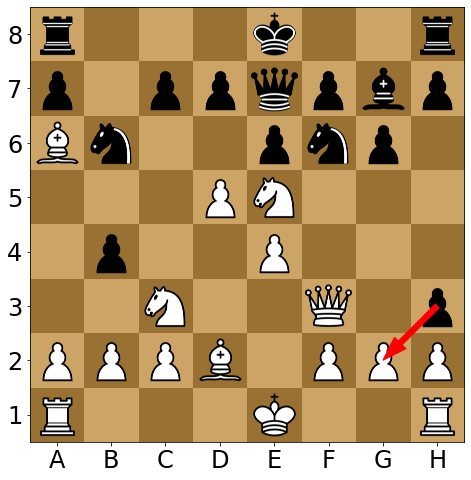

In [17]:
results_df = handle_output(output, 'Parallel v1 (basic)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

@cuda.jit
def kernel_v1(boards, out_scores): # Kernel
    ...

def parallel_v1_minimax_alphabeta(chess_game, search_depth, alpha = -inf, beta = inf):
    # Get all possible moves
    moves = possible_moves(chess_game)


    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Sequencial on search_depth > 1
    if search_depth > 1:

        # Evaluate each possible move and find the best one
        for move in moves:
            chess_game.move(move)
            evaluation = -parallel_v1_minimax_alphabeta(chess_game, search_depth - 1, -beta, -alpha)
            chess_game.undo_move()

            if evaluation >= beta:
                return beta

            alpha = max(alpha, evaluation)

        return alpha


    # Parallel evaluation of child nodes on search_depth = 1
    else:

        # Use maximum number of threads per block allowed
        gpu = cuda.get_current_device()
        block_size = gpu.MAX_THREADS_PER_BLOCK
        grid_size  = (n_boards * 64 - 1) // block_size + 1
        smem_size  = gpu.MAX_THREADS_PER_BLOCK * 4

        # Combine all boards into 1 array
        boards = []
        for move in moves:
            chess_game.move(move)
            boards += chess_game.board()
            chess_game.undo_move()


        # Call kernel
        d_boards     = cuda.to_device(np.array(boards, dtype = np.int8))
        d_out_scores = cuda.device_array(len(moves), dtype = np.float32)

        kernel_v1[grid_size, block_size, 0, smem_size](d_boards, d_out_scores)

        out_scores = d_out_scores.copy_to_host()

        # Evaluate each possible move and find the best one
        for score in out_scores:
            if -score >= beta:
                return beta

            alpha = max(alpha, -score)

        return alpha

```

In [18]:
%%writefile parallelv1_minimax_alphabeta.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

move, score = find_move(game, 2, version = 3) # Run once to compile kernel

start = time.time()
move, score = find_move(game, args.search_depth, version = 4)
end = time.time()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv1_minimax_alphabeta.py


In [19]:
%%capture output
!python parallelv1_minimax_alphabeta.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,359.34437,3107697
1,Sequencial (alpha-beta),-1.2,2.14137,16293
2,Sequencial (alpha-beta + move sorting),-1.2,1.40612,8579
3,Parallel v1 (basic),-1.2,113.96438,3107697
4,Parallel v1 (alpha-beta),-1.2,3.80458,107193


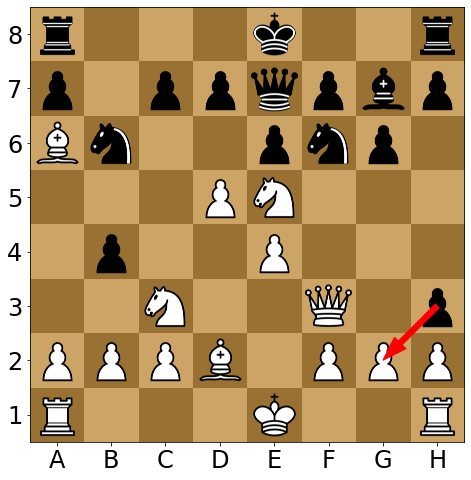

In [20]:
results_df = handle_output(output, 'Parallel v1 (alpha-beta)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

def sort_moves(moves): # Move sorting function
    ...

@cuda.jit
def kernel_v1(boards, out_scores): # Kernel
    ...

def parallel_v1_minimax_alphabeta_movesorting(chess_game, search_depth, alpha = -inf, beta = inf):
    # Get all possible moves and sort
    moves = possible_moves(chess_game)
    moves = sort_moves(moves)

    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Sequencial on search_depth > 1
    if search_depth > 1:

        # Evaluate each possible move and find the best one
        for move in moves:
            chess_game.move(move)
            evaluation = -parallel_v1_minimax_alphabeta_movesorting(chess_game, search_depth - 1, -beta, -alpha)
            chess_game.undo_move()

            if evaluation >= beta:
                return beta

            alpha = max(alpha, evaluation)

        return alpha


    # Parallel evaluation of child nodes on search_depth = 1
    else:

        # Use maximum number of threads per block allowed
        gpu = cuda.get_current_device()
        block_size = gpu.MAX_THREADS_PER_BLOCK
        grid_size  = (n_boards * 64 - 1) // block_size + 1
        smem_size  = gpu.MAX_THREADS_PER_BLOCK * 4

        # Combine all boards into 1 array
        boards = []
        for move in moves:
            chess_game.move(move)
            boards += chess_game.board()
            chess_game.undo_move()


        # Call kernel
        d_boards     = cuda.to_device(np.array(boards, dtype = np.int8))
        d_out_scores = cuda.device_array(len(moves), dtype = np.float32)

        kernel_v1[grid_size, block_size, 0, smem_size](d_boards, d_out_scores)

        out_scores = d_out_scores.copy_to_host()

        # Evaluate each possible move and find the best one
        for score in out_scores:
            if -score >= beta:
                return beta

            alpha = max(alpha, -score)

        return alpha

```

In [21]:
%%writefile parallelv1_minimax_alphabeta_movesorting.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

move, score = find_move(game, 2, version = 3) # Run once to compile kernel

start = time.time()
move, score = find_move(game, args.search_depth, version = 5)
end = time.time()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv1_minimax_alphabeta_movesorting.py


In [22]:
%%capture output
!python parallelv1_minimax_alphabeta_movesorting.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,359.34437,3107697
1,Sequencial (alpha-beta),-1.2,2.14137,16293
2,Sequencial (alpha-beta + move sorting),-1.2,1.40612,8579
3,Parallel v1 (basic),-1.2,113.96438,3107697
4,Parallel v1 (alpha-beta),-1.2,3.80458,107193
5,Parallel v1 (alpha-beta + move sorting),-1.2,3.59041,102329


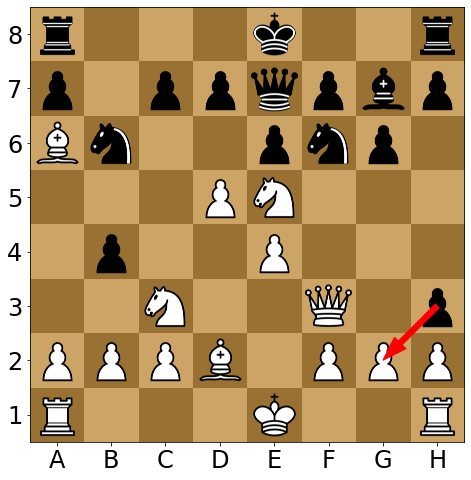

In [23]:
results_df = handle_output(output, 'Parallel v1 (alpha-beta + move sorting)', results_df)
results_df

### **PHIÊN BẢN SONG SONG 2**

#### Ý TƯỞNG

Cách tiếp cận của phương pháp này là duyệt node con đầu tiên, các node con còn lại được tính điểm song song trên GPU. Điểm của từng node dược duyệt song song được tính bằng thuật toán tìm kiếm minimax tuần tự.

![Parallel v2 diagram](./images/parallel_v2_diagram.png "Parallel v2 diagram")

Thử thách khi cài đặt hàm kernel này là nghĩ ra cách chạy một thuật toán mang tính đệ quy như tìm kiếm minimax trên GPU.

Một cách để thực hiện điều này là dùng nhiều thread trên cùng 1 block, mỗi thread ứng với 1 độ sâu tìm kiếm. Thread thứ `i` sẽ nhờ thread thứ `i + 1` tính điểm cho node con của mình. Trường hợp `i = search_depth` thì thread đó sẽ tính điểm cho bàn cờ.

Cách tiếp cận này sử dụng 1 hàm kernel, trong đó:
- Đầu vào là các mảng chứa thông tin của các thế cờ (bàn cờ, quyền nhập thành, ...)
- Đầu ra là điểm số tương ứng của từng thế cờ

Kernel này sử dụng tối thiểu 64 thread trên 1 block, mỗi block ứng với 1 node con.

```python

@cuda.jit(device = True)
def possible_moves_device(board, castling_right, en_passant_target, halfmove, out_moves): # Find all possible moves,
    ...                                                                                   # return number of moves found

@cuda.jit(device = True)
def evaluate_board_device(board):  # Evaluate board
    ...

@cuda.jit(device = True)
def check_draw_device(board, castling_right, en_passant_target, halfmove): # Draw check
    ...

@cuda.jit(device = True)
def move_device(board, board2, castling_right, en_passant_target, halfmove, move): # Make a move,
    ...                                                                            # return updated game info

@cuda.jit
def kernel_v2(boards, castling_rights, en_passant_targets, halfmoves, search_depth, alpha, beta, out_scores):
    bid = cuda.blockIdx.x

    # Slice shared memory
    s_shared_i8  = cuda.shared.array(0, dtype = np.int8)
    s_shared_i32 = cuda.shared.array(0, dtype = np.int32)
    s_shared_f32 = cuda.shared.array(0, dtype = np.float32)

    s_boards             = s_shared_i8 [                        : 64 * (search_depth + 1)]
    s_castling_rights    = s_shared_i8 [64 * (search_depth + 1) : 65 * (search_depth + 1)]
    s_en_passant_targets = s_shared_i8 [65 * (search_depth + 1) : 66 * (search_depth + 1)]
    s_halfmoves          = s_shared_i8 [66 * (search_depth + 1) : 67 * (search_depth + 1)]
    s_status             = s_shared_i32[17 * (search_depth + 1) : 18 * (search_depth + 1)]
    s_alphas             = s_shared_f32[18 * (search_depth + 1) : 19 * (search_depth + 1)]
    s_betas              = s_shared_f32[19 * (search_depth + 1) : 20 * (search_depth + 1)]

    # Copy board and other info to shared memory
    if cuda.threadIdx.x < 64:
        s_boards[cuda.threadIdx.x] = boards[bid * 64 + cuda.threadIdx.x]
    if cuda.threadIdx.x == 0:
        s_castling_rights[0]    = castling_rights[bid]
        s_en_passant_targets[0] = en_passant_targets[bid]
        s_halfmoves[0]          = halfmoves[bid]
        s_alphas[0]             = alpha
        s_betas[0]              = beta
    if cuda.threadIdx.x <= search_depth:
        s_status[cuda.threadIdx.x] = 0 if cuda.threadIdx.x == 0 else 1
    cuda.syncthreads()

    # Allocate array to find moves
    out_moves = cuda.local.array(256, dtype = np.int32)

    if cuda.threadIdx.x <= search_depth:
        while True:
            while cuda.atomic.add(s_status, cuda.threadIdx.x, 0) == 1:  # Wait for job or exit
                continue
            if cuda.atomic.add(s_status, cuda.threadIdx.x, 0) > 1: # Exit
                break

            board             = s_boards[64 * cuda.threadIdx.x : 64 * (cuda.threadIdx.x + 1)]
            castling_right    = s_castling_rights[cuda.threadIdx.x]
            en_passant_target = s_en_passant_targets[cuda.threadIdx.x]
            halfmove          = s_halfmoves[cuda.threadIdx.x]

            if cuda.threadIdx.x == search_depth: # Leaf node
                s_alpha[cuda.threadIdx.x] = evaluate_board_device(board)
            else:
                # Find all moves, sort if needed
                n_moves = possible_moves_device(board, castling_right, en_passant_target, halfmove, out_moves)

                if n_moves == 0:
                    s_alphas[cuda.threadIdx.x] = 0.0 if check_draw_device(board, castling_right, en_passant_target, halfmove) else -inf
                else:
                    board2 = s_boards[64 * (cuda.threadIdx.x + 1) : 64 * (cuda.threadIdx.x + 2)]

                    for i in range(n_moves):

                        # Make move
                        move = out_moves[i]
                        castling_right2, en_passant_target2, halfmove2 = move_device(board, board2, 
                            castling_right, en_passant_target, halfmove, move)

                        # Send info to next thread
                        s_castling_rights[cuda.threadIdx.x + 1]    = castling_right2
                        s_en_passant_targets[cuda.threadIdx.x + 1] = en_passant_target2
                        s_halfmoves[cuda.threadIdx.x + 1]          = halfmove2
                        s_alphas[cuda.threadIdx.x + 1]             = -s_betas[cuda.threadIdx.x]
                        s_betas[cuda.threadIdx.x + 1]              = -s_alphas[cuda.threadIdx.x]

                        # Activate next thread
                        cuda.atomic.exch(s_status, cuda.threadIdx.x + 1, 0)

                        # Wait for next thread to finish
                        while cuda.atomic.add(s_status, cuda.threadIdx.x + 1, 0) == 0:
                            continue

                        if alpha_beta_prunning and -s_alphas[cuda.threadIdx.x + 1] >= s_betas[cuda.threadIdx.x]:
                            s_alphas[cuda.threadIdx.x] = s_betas[cuda.threadIdx.x]
                            break
                            
                        if -s_alphas[cuda.threadIdx.x + 1] > s_alphas[cuda.threadIdx.x]:
                            s_alphas[cuda.threadIdx.x] = -s_alphas[cuda.threadIdx.x + 1]

            # If the root thread finish, exit on all threads                
            if cuda.threadIdx.x == 0:
                out_scores[bid] = s_alphas[0]
                for i in range(search_depth + 1):
                    cuda.atomic.exch(s_status, i, 2)

            # Else just update status
            else:
                cuda.atomic.exch(s_status, cuda.threadIdx.x, 1)

```

#### MINIMAX CƠ BẢN

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

@cuda.jit
def kernel_v2(boards, castling_rights, en_passant_targets, halfmoves, search_depth, out_scores): # Kernel
    ...

def parallel_v2_minimax(chess_game, search_depth):

    # If search limit is reached, return the score of the current board
    if search_depth == 0:
        return evaluate_board(chess_game)


    # Get all possible moves
    moves = possible_moves(chess_game)


    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Evaluate first move recursively
    chess_game.move(moves[0])
    result = -parallel_v2_minimax(chess_game, search_depth - 1)
    chess_game.undo_move()


    # Evaluate the rest parallely
    if len(moves) > 1:

        block_size = 64
        grid_size  = n_boards
        smem_size  = search_depth * 80

        while block_size < search_depth:
            block_size *= 2

        boards             = []
        castling_rights    = []
        en_passant_targets = []
        halfmoves          = []

        for move in moves[1:]:
            chess_game.move(move)

            boards             += chess_game.board()
            castling_rights    += chess_game.castling_right()
            en_passant_targets += chess_game.en_passant_target()
            halfmoves          += chess_game.halfmove()

            chess_game.undo_move()

        d_boards             = cuda.to_device(np.array(boards            , dtype = np.int8))
        d_casting_rights     = cuda.to_device(np.array(castling_rights   , dtype = np.int8))
        d_en_passant_targets = cuda.to_device(np.array(en_passant_targets, dtype = np.int8))
        d_halfmoves          = cuda.to_device(np.array(halfmoves         , dtype = np.int8))
        d_out_scores         = cuda.device_array(len(moves) - 1, dtype = np.float32)

        kernel_v2(d_boards, d_castling_rights, d_en_passant_targets, d_halfmoves, search_depth - 1, d_out_scores)

        for score in out_scores:
            result = max(result, -score)

    return result

```

In [24]:
%%writefile parallelv2_minimax_basic.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

move, score = find_move(game, 2, version = 6) # Run once to compile kernel

start = time.time()
move, score = find_move(game, args.search_depth, version = 6)
end = time.time()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv2_minimax_basic.py


In [25]:
%%capture output
!python parallelv2_minimax_basic.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,359.34437,3107697
1,Sequencial (alpha-beta),-1.2,2.14137,16293
2,Sequencial (alpha-beta + move sorting),-1.2,1.40612,8579
3,Parallel v1 (basic),-1.2,113.96438,3107697
4,Parallel v1 (alpha-beta),-1.2,3.80458,107193
5,Parallel v1 (alpha-beta + move sorting),-1.2,3.59041,102329
6,Parallel v2 (basic),-1.2,2.17258,3107697


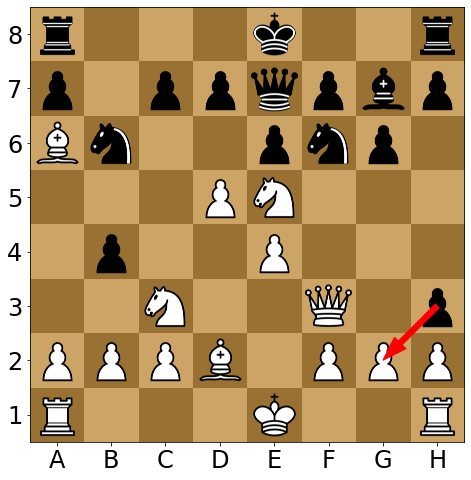

In [26]:
results_df = handle_output(output, 'Parallel v2 (basic)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

@cuda.jit
def kernel_v2(boards, castling_rights, en_passant_targets, halfmoves, search_depth, alpha, beta, out_scores): # Kernel
    ...

def parallel_v2_minimax_alphabeta(chess_game, search_depth, alpha = -inf, beta = inf):

    # If search limit is reached, return the score of the current board
    if search_depth == 0:
        return evaluate_board(chess_game)


    # Get all possible moves
    moves = possible_moves(chess_game)


    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Evaluate first move recursively
    chess_game.move(moves[0])
    evaluation = -parallel_v2_minimax_alphabeta(chess_game, search_depth - 1, -beta, -alpha)
    chess_game.undo_move()

    if evaluation >= beta:
        return beta

    alpha = max(alpha, evaluation)

    # Evaluate the rest parallely
    if len(moves) > 1:

        block_size = 64
        grid_size  = n_boards
        smem_size  = search_depth * 80

        while block_size < search_depth:
            block_size *= 2

        boards             = []
        castling_rights    = []
        en_passant_targets = []
        halfmoves          = []

        for move in moves[1:]:
            chess_game.move(move)

            boards             += chess_game.board()
            castling_rights    += chess_game.castling_right()
            en_passant_targets += chess_game.en_passant_target()
            halfmoves          += chess_game.halfmove()

            chess_game.undo_move()

        d_boards             = cuda.to_device(np.array(boards            , dtype = np.int8))
        d_casting_rights     = cuda.to_device(np.array(castling_rights   , dtype = np.int8))
        d_en_passant_targets = cuda.to_device(np.array(en_passant_targets, dtype = np.int8))
        d_halfmoves          = cuda.to_device(np.array(halfmoves         , dtype = np.int8))
        d_out_scores         = cuda.device_array(len(moves) - 1, dtype = np.float32)

        kernel_v2(d_boards, d_castling_rights, d_en_passant_targets, d_halfmoves, search_depth - 1, -beta, -alpha, d_out_scores)

        for score in out_scores:
            if -score >= beta:
                return beta

            alpha = max(alpha, -score)

    return alpha

```

In [27]:
%%writefile parallelv2_minimax_alphabeta.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

move, score = find_move(game, 2, version = 6) # Run once to compile kernel

start = time.time()
move, score = find_move(game, args.search_depth, version = 7)
end = time.time()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv2_minimax_alphabeta.py


In [28]:
%%capture output
!python parallelv2_minimax_alphabeta.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,359.34437,3107697
1,Sequencial (alpha-beta),-1.2,2.14137,16293
2,Sequencial (alpha-beta + move sorting),-1.2,1.40612,8579
3,Parallel v1 (basic),-1.2,113.96438,3107697
4,Parallel v1 (alpha-beta),-1.2,3.80458,107193
5,Parallel v1 (alpha-beta + move sorting),-1.2,3.59041,102329
6,Parallel v2 (basic),-1.2,2.17258,3107697
7,Parallel v2 (alpha-beta),-1.2,0.26052,19804


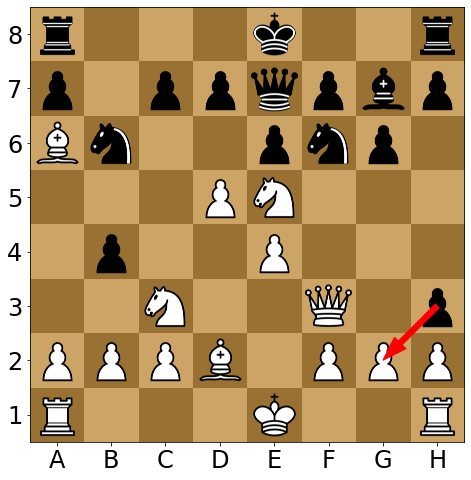

In [29]:
results_df = handle_output(output, 'Parallel v2 (alpha-beta)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

def sort_moves(moves): # Move sorting function
    ...

@cuda.jit
def kernel_v2(boards, castling_rights, en_passant_targets, halfmoves, search_depth, alpha, beta, out_scores): # Kernel
    ...

def parallel_v2_minimax_alphabeta_movesorting(chess_game, search_depth, alpha = -inf, beta = inf):

    # If search limit is reached, return the score of the current board
    if search_depth == 0:
        return evaluate_board(chess_game)


    # Get all possible moves
    moves = possible_moves(chess_game)
    moves = sort_moves(moves)


    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Evaluate first move recursively
    chess_game.move(moves[0])
    evaluation = -parallel_v2_minimax_alphabeta_movesorting(chess_game, search_depth - 1, -beta, -alpha)
    chess_game.undo_move()

    if evaluation >= beta:
        return beta

    alpha = max(alpha, evaluation)

    # Evaluate the rest parallely
    if len(moves) > 1:

        block_size = 64
        grid_size  = n_boards
        smem_size  = search_depth * 80

        while block_size < search_depth:
            block_size *= 2

        boards             = []
        castling_rights    = []
        en_passant_targets = []
        halfmoves          = []

        for move in moves[1:]:
            chess_game.move(move)

            boards             += chess_game.board()
            castling_rights    += chess_game.castling_right()
            en_passant_targets += chess_game.en_passant_target()
            halfmoves          += chess_game.halfmove()

            chess_game.undo_move()

        d_boards             = cuda.to_device(np.array(boards            , dtype = np.int8))
        d_casting_rights     = cuda.to_device(np.array(castling_rights   , dtype = np.int8))
        d_en_passant_targets = cuda.to_device(np.array(en_passant_targets, dtype = np.int8))
        d_halfmoves          = cuda.to_device(np.array(halfmoves         , dtype = np.int8))
        d_out_scores         = cuda.device_array(len(moves) - 1, dtype = np.float32)

        kernel_v2(d_boards, d_castling_rights, d_en_passant_targets, d_halfmoves, search_depth - 1, -beta, -alpha, d_out_scores)

        for score in out_scores:
            if -score >= beta:
                return beta

            alpha = max(alpha, -score)

    return alpha

```

In [30]:
%%writefile parallelv2_minimax_alphabeta_movesorting.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

move, score = find_move(game, 2, version = 6) # Run once to compile kernel

start = time.time()
move, score = find_move(game, args.search_depth, version = 8)
end = time.time()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv2_minimax_alphabeta_movesorting.py


In [31]:
%%capture output
!python parallelv2_minimax_alphabeta_movesorting.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Sequencial (basic),-1.2,359.34437,3107697
1,Sequencial (alpha-beta),-1.2,2.14137,16293
2,Sequencial (alpha-beta + move sorting),-1.2,1.40612,8579
3,Parallel v1 (basic),-1.2,113.96438,3107697
4,Parallel v1 (alpha-beta),-1.2,3.80458,107193
5,Parallel v1 (alpha-beta + move sorting),-1.2,3.59041,102329
6,Parallel v2 (basic),-1.2,2.17258,3107697
7,Parallel v2 (alpha-beta),-1.2,0.26052,19804
8,Parallel v2 (alpha-beta + move sorting),-1.2,0.32208,12138


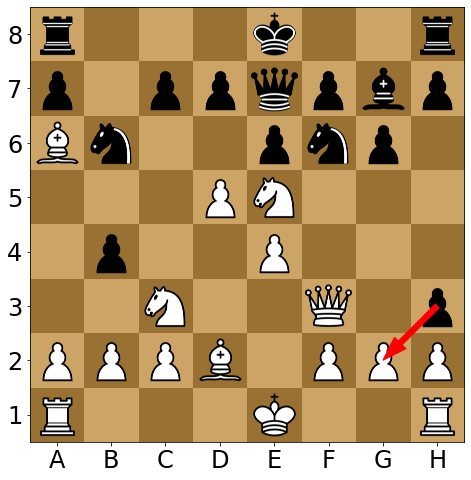

In [32]:
results_df = handle_output(output, 'Parallel v2 (alpha-beta + move sorting)', results_df)
results_df